In [3]:
!pip install FRUFS

  Using cached FRUFS-1.0.2-py3-none-any.whl (5.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 1.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.3 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [21]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#import plotnine
#from plotnine import *

In [22]:
from FRUFS import FRUFS
#import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

In [23]:
# 데이터 불러오기 
df = pd.read_csv('/Data2/hm22/New/sample.csv', encoding='utf-8')
df = df.drop(['Unnamed: 0'], axis = 1)

In [24]:
df

,profile_id,album_id,ss_id,log_time_x,log_time_y,diff,diff_ss,diff_ox,watch_time,total_time,...,search_ox,prefer,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,15.0,2022-03-01 11:56:53,2022-03-01 11:57:19,2022-03-01 11:58:05,0 days 00:00:46,46.0,True,46.0,46.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
1,3,16.0,2022-03-01 11:56:53,2022-03-01 11:58:09,2022-03-01 11:59:54,0 days 00:01:45,105.0,False,104.0,105.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
2,3,17.0,2022-03-01 11:56:53,2022-03-01 11:59:58,2022-03-01 12:01:14,0 days 00:01:16,76.0,True,76.0,76.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
3,3,18.0,2022-03-01 11:56:53,2022-03-01 12:01:18,2022-03-01 12:02:26,0 days 00:01:08,68.0,False,67.0,68.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
4,3,19.0,2022-03-01 11:56:53,2022-03-01 12:02:29,2022-03-01 12:04:00,0 days 00:01:31,91.0,False,90.0,90.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914989,33032,381.0,2022-04-27 15:50:09,2022-04-27 15:56:42,2022-04-27 15:56:53,0 days 00:00:11,11.0,False,463.0,464.0,...,0.0,4.0,F,5,P03,P05,P07,K01,K05,K09
1914990,33032,381.0,2022-04-27 15:50:09,2022-04-27 15:56:42,2022-04-27 15:56:09,-1 days +23:59:27,-33.0,False,462.0,463.0,...,0.0,4.0,F,5,P03,P05,P07,K01,K05,K09
1914991,33032,375.0,2022-04-27 15:50:09,2022-04-27 15:55:59,2022-04-27 15:55:26,-1 days +23:59:27,-33.0,False,658.0,659.0,...,0.0,4.0,F,5,P03,P05,P07,K01,K05,K09
1914992,33032,125.0,2022-04-27 15:58:39,2022-04-27 15:58:10,2022-04-27 15:58:26,0 days 00:00:16,16.0,False,10.0,520.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09


In [25]:
df.columns

Index(['profile_id', 'album_id', 'ss_id', 'log_time_x', 'log_time_y', 'diff',
       'diff_ss', 'diff_ox', 'watch_time', 'total_time', 'continuous_play_x',
       'continuous_play_y', 'act_target_dtl_x', 'act_target_dtl',
       'short_trailer', 'payment', 'time_slot', 'search_ox', 'prefer', 'sex',
       'age', 'pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2',
       'pr_interest_keyword_cd_3', 'ch_interest_keyword_cd_1',
       'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'],
      dtype='object')

In [26]:
# 시청 시작 데이터에서 연속재생여부 Y -> 1: 연속재생, N -> 5: 미정 으로 변환
df.loc[(df['continuous_play_x'] == 'Y'), 'continuous_play_x'] = 1
df.loc[(df['continuous_play_x'] == 'N'), 'continuous_play_x'] = 0

In [27]:
df['short_trailer'] = df['short_trailer'].apply(lambda x: 1 if x == 'Y' else 0)
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'M' else 0)

In [28]:
df['act_target_dtl'] = df['act_target_dtl'].str.split('D').str[1]
df['act_target_dtl_x'] = df['act_target_dtl_x'].str.split('D').str[1]

In [29]:
# 주의 : 결측치가 없어야함
for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    enc_1 = (df.groupby(i).size()) / len(df)
    enc_1
    
    df['{}_encode'.format(i)] = df[i].apply(lambda x : enc_1[x])
    
#인코딩 전 변수는 제거 
df = df.drop(['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
                'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'],axis=1)

In [30]:
X = df.loc[:, ~df.columns.isin(['album_id'])] # FEATURE DATA
y = df['album_id'] # LABEL DATA

In [31]:
X = X.drop(['profile_id', 'ss_id', 'log_time_x',
            'log_time_y', 'diff', 'diff_ss', 'diff_ox',
            ], axis = 1)
X

,watch_time,total_time,continuous_play_x,continuous_play_y,act_target_dtl_x,act_target_dtl,short_trailer,payment,time_slot,search_ox,prefer,sex,age,pr_interest_keyword_cd_1_encode,pr_interest_keyword_cd_2_encode,pr_interest_keyword_cd_3_encode,ch_interest_keyword_cd_1_encode,ch_interest_keyword_cd_2_encode,ch_interest_keyword_cd_3_encode
0,46.0,46.0,1,1.0,003,049,0,0.0,2.0,0.0,4.0,0,5,0.215737,0.118302,0.20921,0.59852,0.156005,0.069369
1,104.0,105.0,1,1.0,003,049,0,0.0,2.0,0.0,4.0,0,5,0.215737,0.118302,0.20921,0.59852,0.156005,0.069369
2,76.0,76.0,1,1.0,003,049,0,0.0,2.0,0.0,4.0,0,5,0.215737,0.118302,0.20921,0.59852,0.156005,0.069369
3,67.0,68.0,1,1.0,003,049,0,0.0,3.0,0.0,4.0,0,5,0.215737,0.118302,0.20921,0.59852,0.156005,0.069369
4,90.0,90.0,1,0.0,003,049,0,0.0,3.0,0.0,4.0,0,5,0.215737,0.118302,0.20921,0.59852,0.156005,0.069369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914989,463.0,464.0,0,1.0,003,049,0,0.0,3.0,0.0,4.0,0,5,0.174492,0.122729,0.20921,0.59852,0.073859,0.085907
1914990,462.0,463.0,0,1.0,003,049,0,0.0,3.0,0.0,4.0,0,5,0.174492,0.122729,0.20921,0.59852,0.073859,0.085907
1914991,658.0,659.0,1,1.0,003,049,0,0.0,3.0,0.0,4.0,0,5,0.174492,0.122729,0.20921,0.59852,0.073859,0.085907
1914992,10.0,520.0,1,0.0,003,049,0,0.0,3.0,0.0,1.0,0,5,0.174492,0.122729,0.20921,0.59852,0.073859,0.085907


In [32]:
model_frufs = FRUFS(model_r = LGBMRegressor(),k = 0.2)
model_frufs.fit(X)

X_pruned = model_frufs.transform(X)
print(X_pruned.shape)



Progress bar: 100%|█████████████████████████████| 19/19 [05:09<00:00, 16.29s/it]


(1914994, 4)


NameError: name 'mpl' is not defined

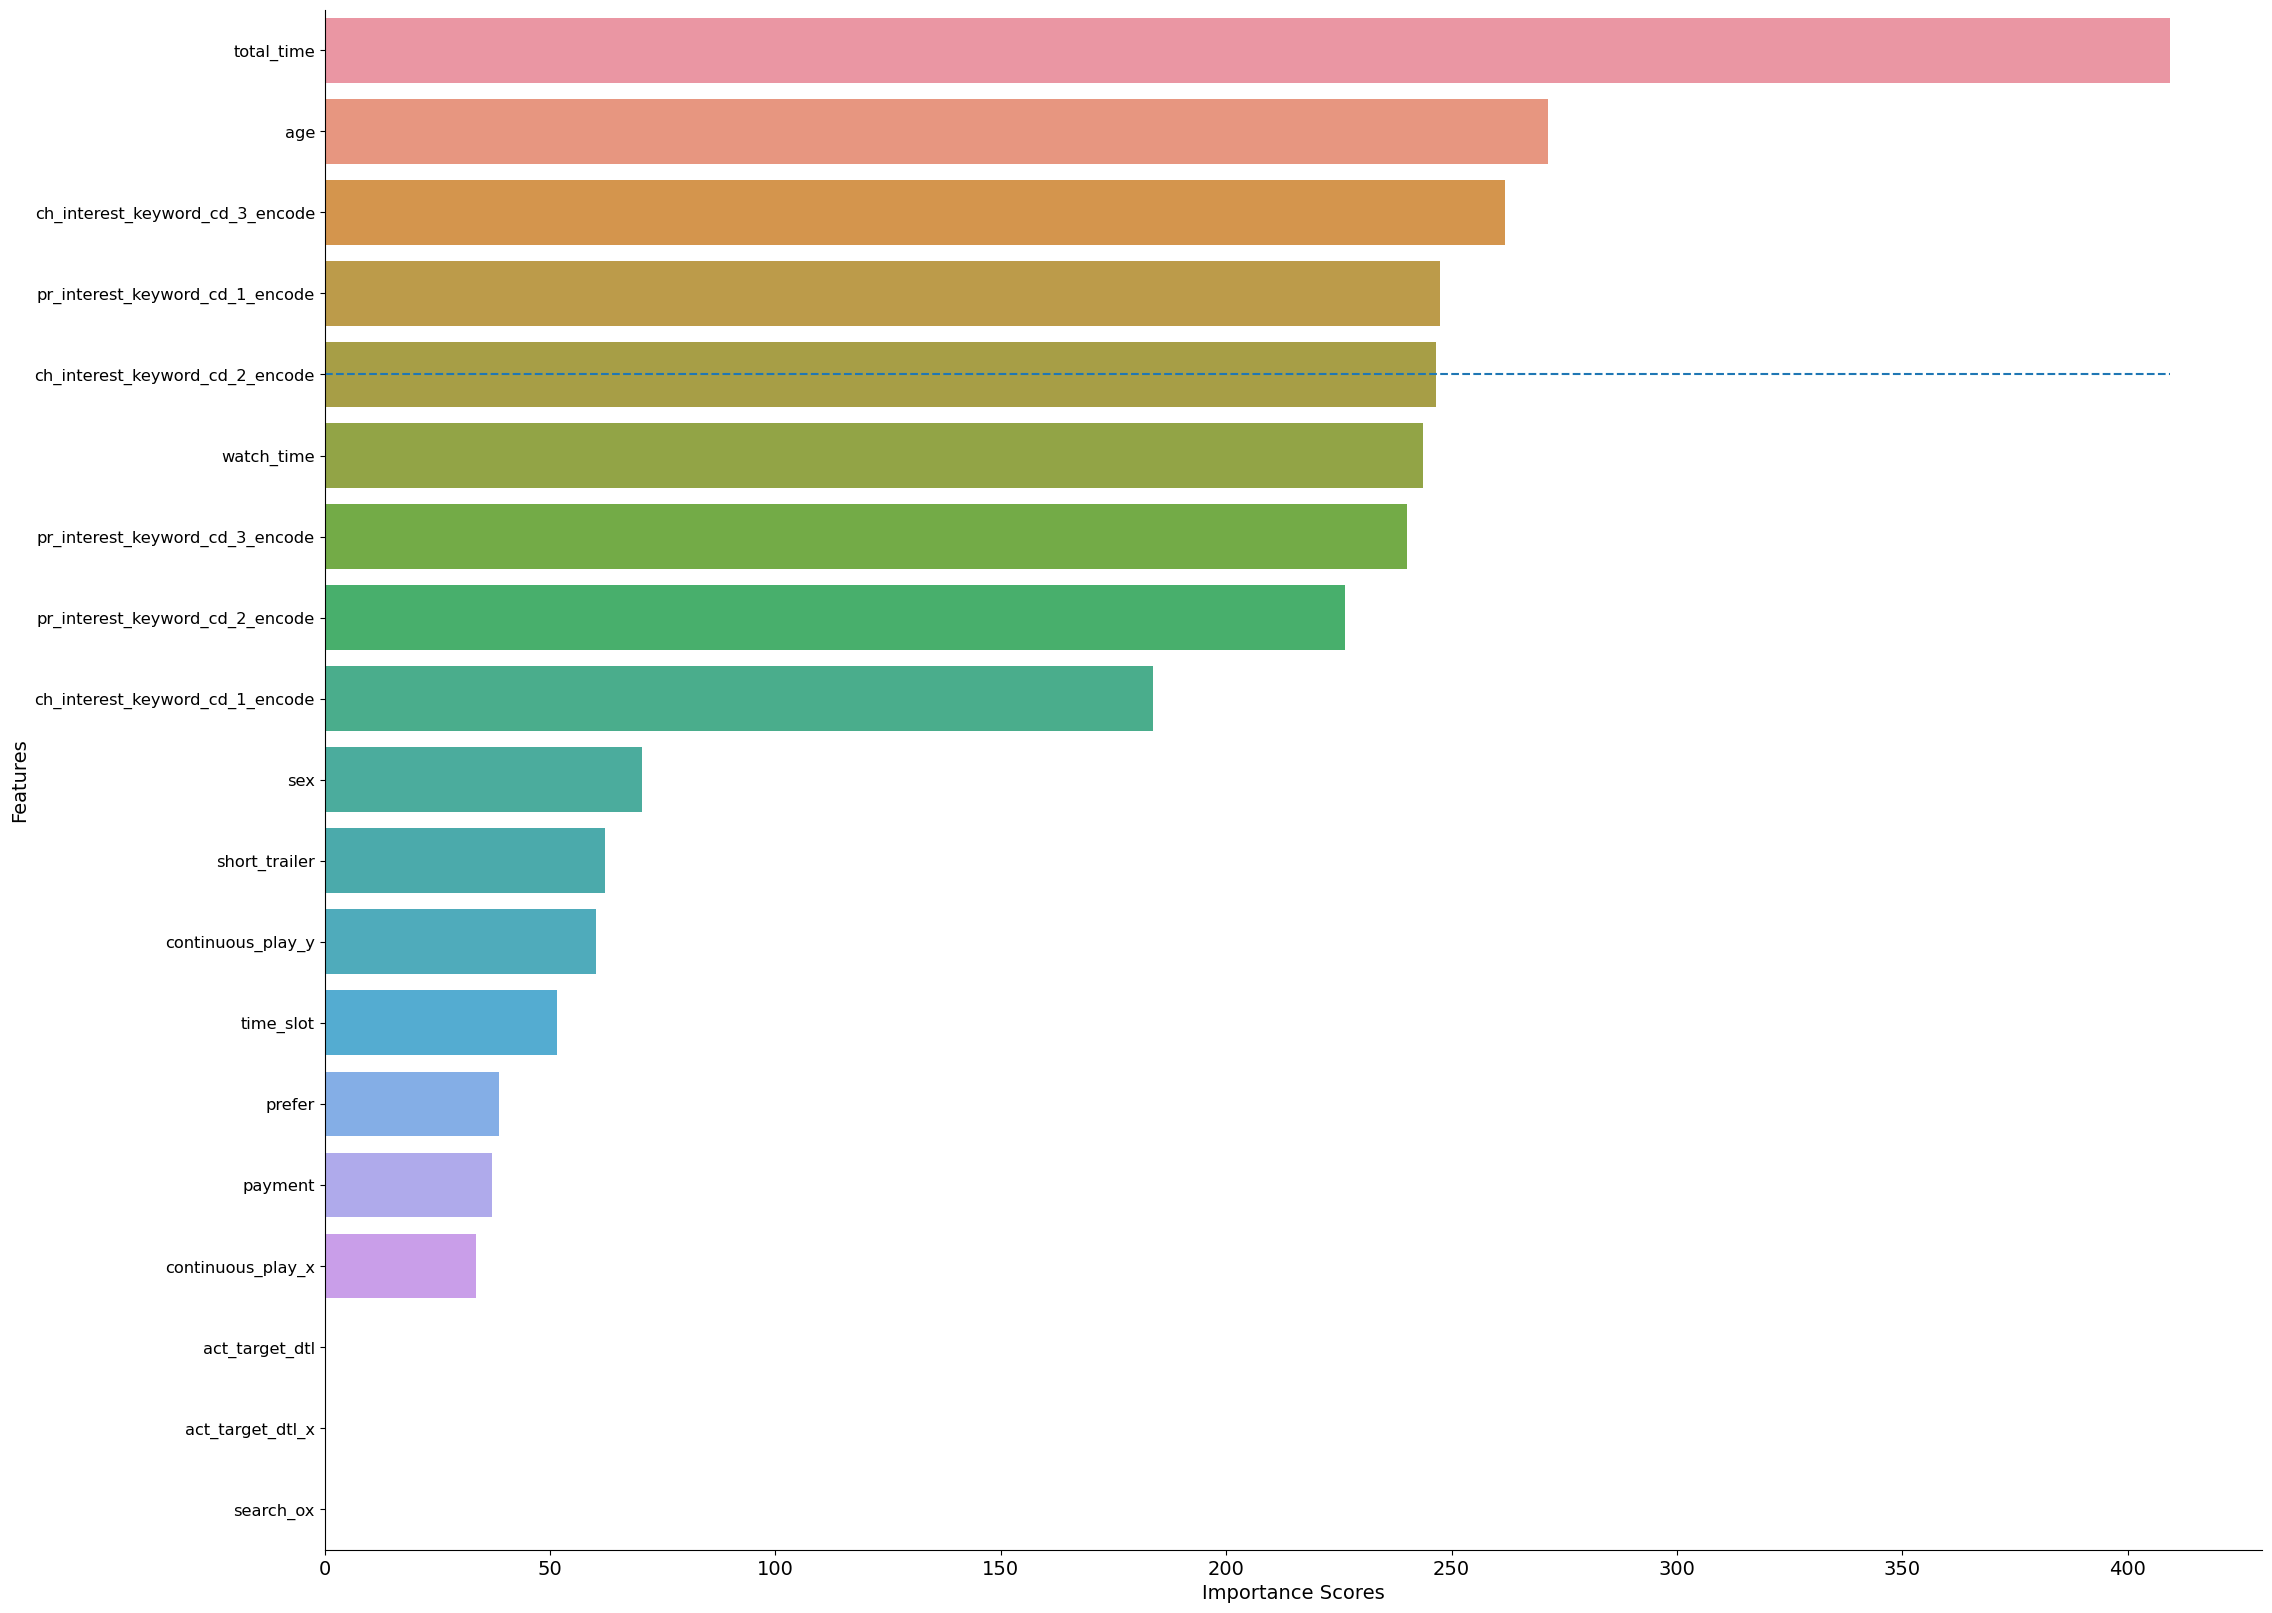

['total_time', 'age', 'ch_interest_keyword_cd_3_encode', 'pr_interest_keyword_cd_1_encode']


In [33]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 7

plt.style.use("default")
mpl.rcParams['font.size'] = 14
plt.figure(figsize=(25, 20), facecolor='white')

model_frufs.feature_importance()

FRUFS_LGBMRegressor_var = list(X_pruned.columns)
print(FRUFS_LGBMRegressor_var)